In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
import gpt as g

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.nn.lptc import v_LPTC_NG
from qcd_ml.qcd.dirac import dirac_wilson_clover
from qcd_ml.base.paths import PathBuffer

from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice

from qcd_ml.util.solver import GMRES_restarted
from qcd_ml.util.qcd.multigrid import ZPP_Multigrid

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: pc1011901129
--------------------------------------------------------------------------


SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

/home/knd35666/.local/lib/python3.12/site-packages/torch/_inductor/lowering.py:1612: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


In [2]:
def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()


def l2norm(v):
    return (v * v.conj()).real.sum()

In [4]:
U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)


w = dirac_wilson_clover(U, -0.58, 1.0)

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.58,
    "csw_r": 1.0,
    "csw_t": 1.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))

GPT :      73.902922 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :      73.909704 s : Switching view to [1,1,1,1]/Read
GPT :      73.957341 s : Read 0.00109863 GB at 0.0230576 GB/s (0.0468055 GB/s for distribution, 0.0454568 GB/s for reading + checksum, 2.54726 GB/s for checksum, 1 views per node)
GPT :      73.974049 s : Read 0.00109863 GB at 0.0679586 GB/s (3.84 GB/s for distribution, 0.0691965 GB/s for reading + checksum, 2.2489 GB/s for checksum, 1 views per node)
GPT :      73.988766 s : Read 0.00109863 GB at 0.0768807 GB/s (3.03958 GB/s for distribution, 0.0788906 GB/s for reading + checksum, 2.0599 GB/s for checksum, 1 views per node)
GPT :      74.004420 s : Read 0.00109863 GB at 0.0810968 GB/s (2.96716 GB/s for distribution, 0.0833937 GB/s for reading + checksum, 3.25654 GB/s for checksum, 1 views per node)
GPT :      74.005446 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.106836 s


In [5]:
mg = ZPP_Multigrid.load("mg_setup.pt")

/home/knd35666/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml/src/qcd_ml/util/qcd/multigrid.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  args = torch.load(filenam

In [8]:
psi_coarse = mg.v_project(vec)
w_coarse = mg.get_coarse_operator(w)

In [11]:
paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(3, -1)]]

layer = v_LPTC_NG(1, 1, paths, psi_coarse.shape[:-1], 12)

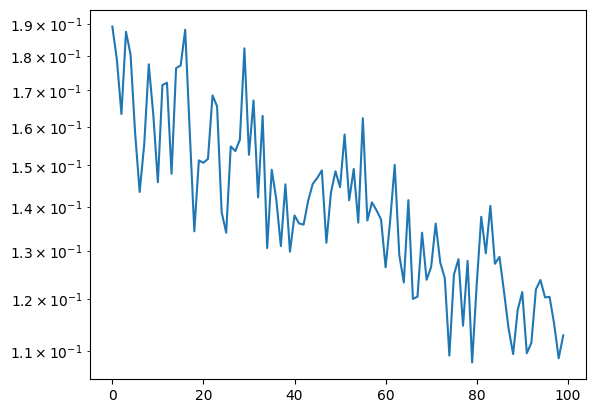

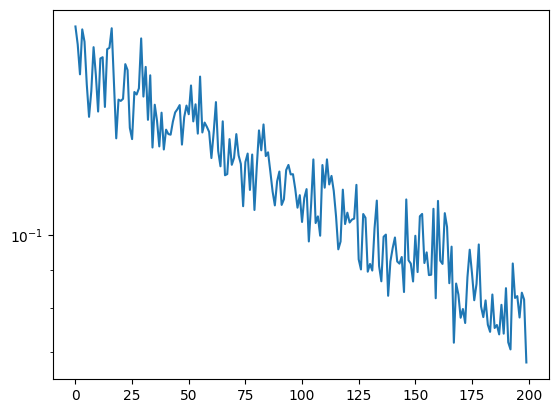

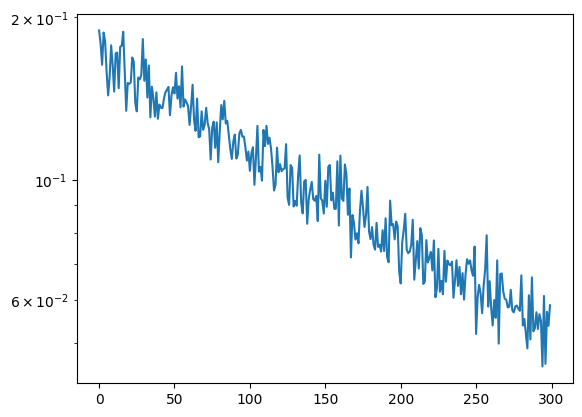

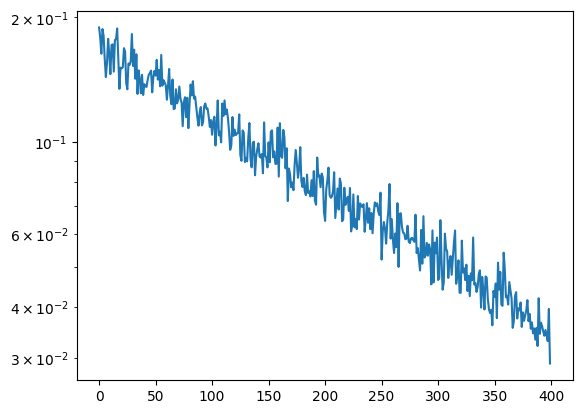

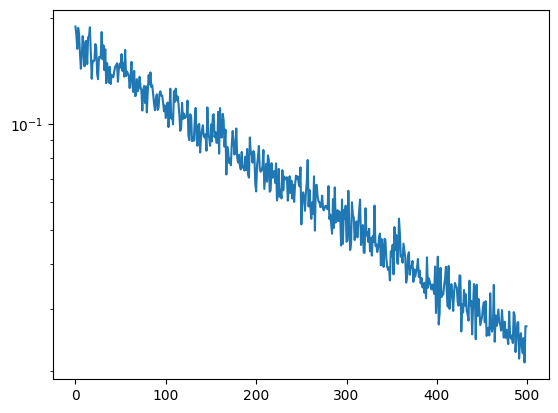

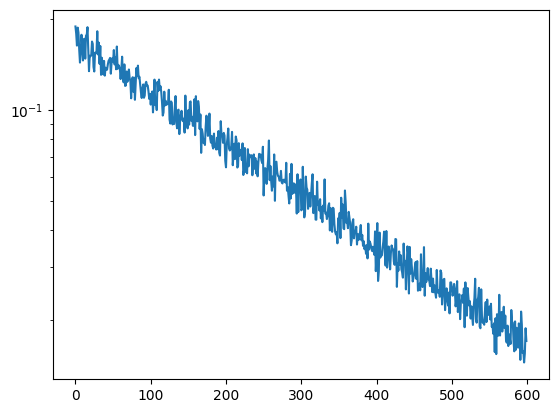

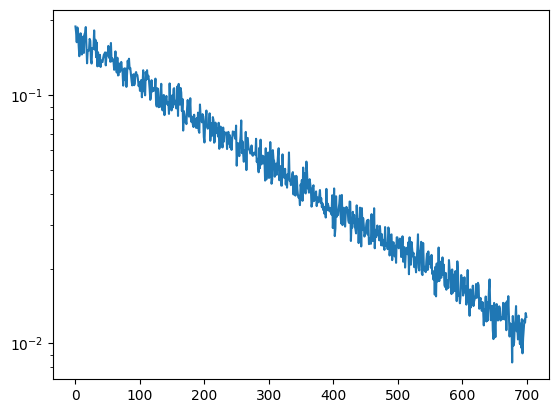

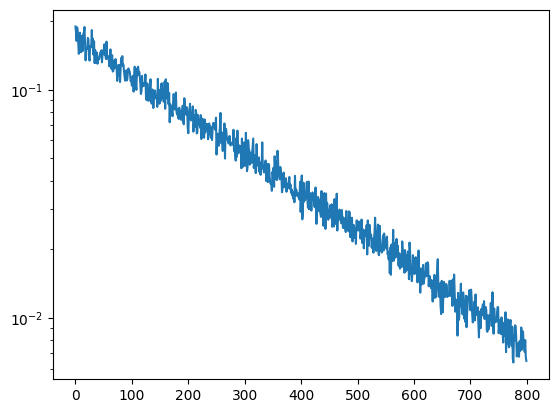

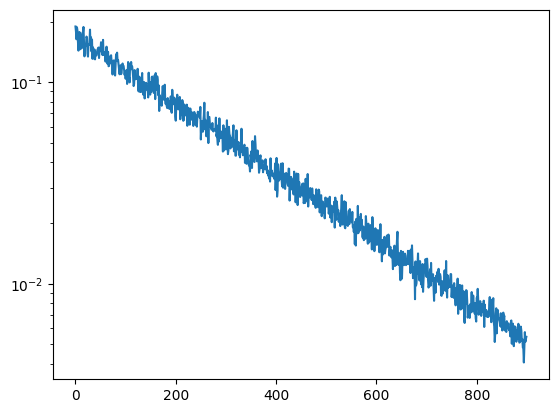

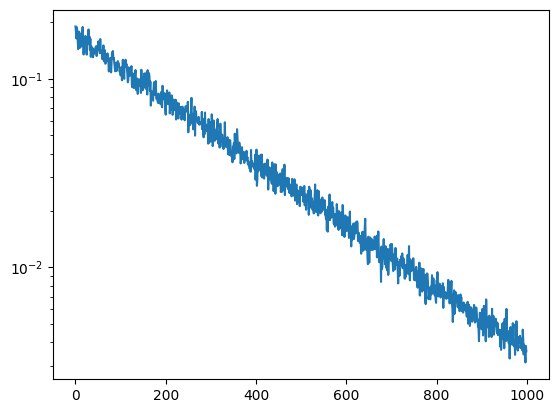

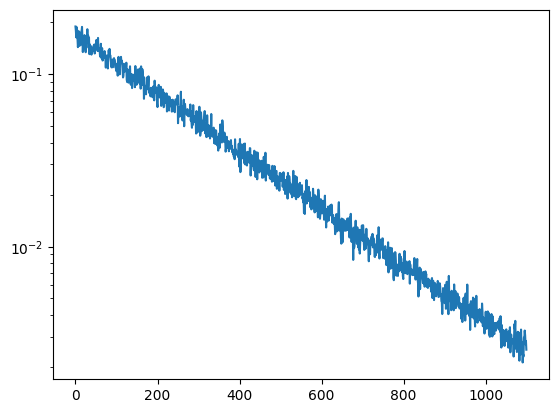

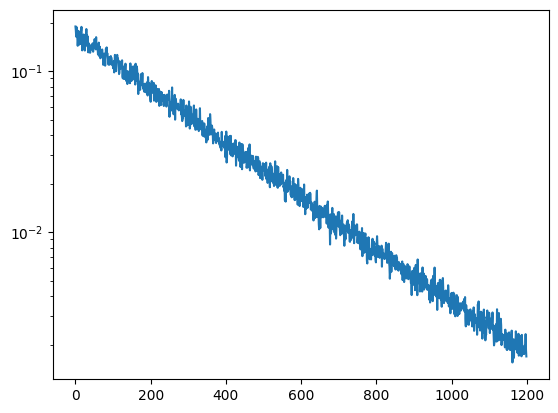

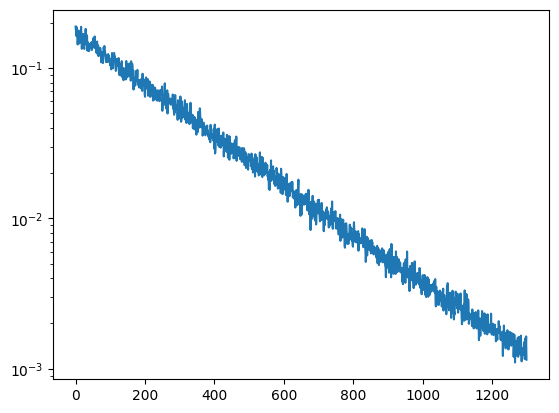

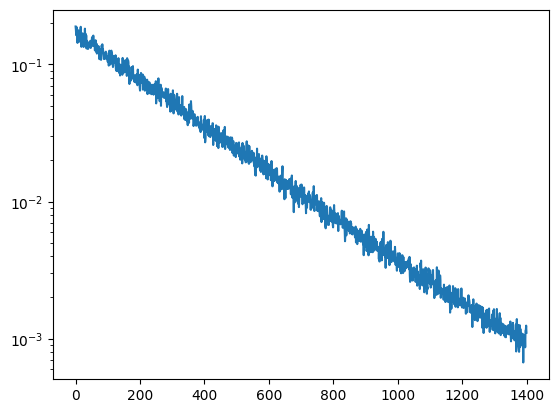

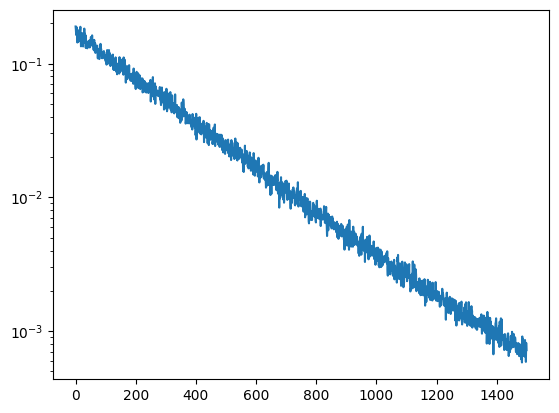

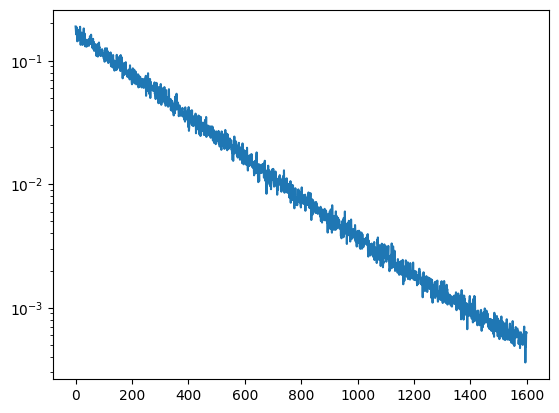

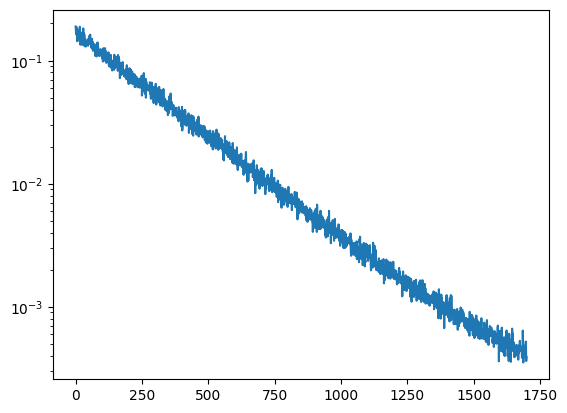

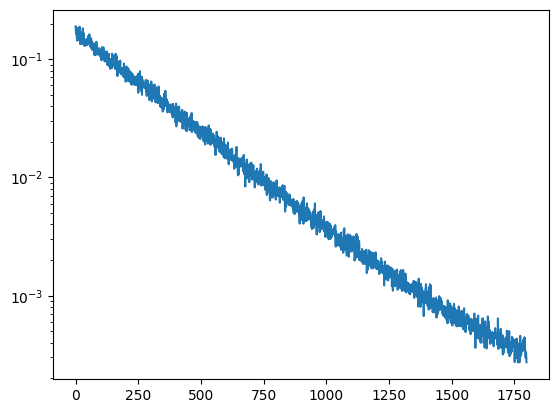

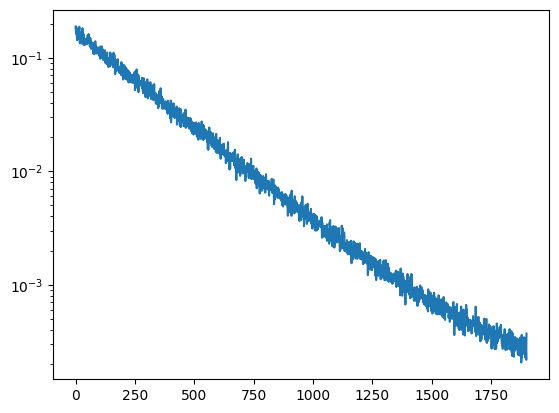

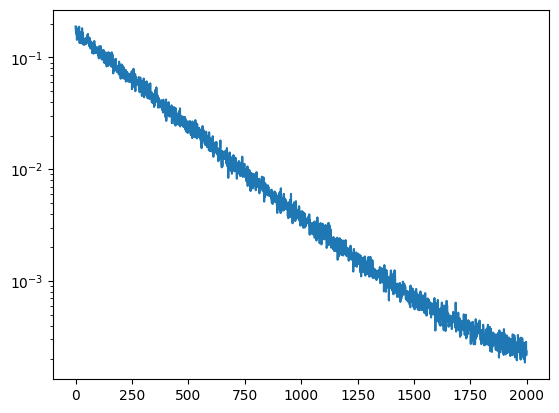

In [12]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)

n_training = 2000
check_every = 1
plot_every = 100

loss = np.zeros(n_training)


for t in range(1, n_training+1):
    vec = torch.randn_like(psi_coarse)
    
    Dvec = w_coarse(vec)
    
    norm = l2norm(Dvec)
    Dvec = Dvec / norm
    vec = vec / norm
    
    sDvec = torch.stack([Dvec])
    score = complex_mse_loss(layer.forward(sDvec), torch.stack([vec]))
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|N/A>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    

    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|N/A>", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")
        plt.show()

print()

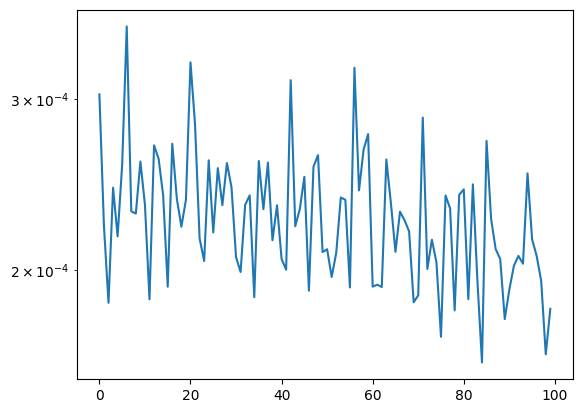

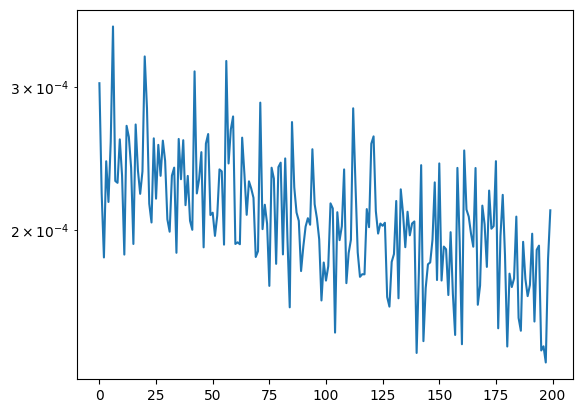

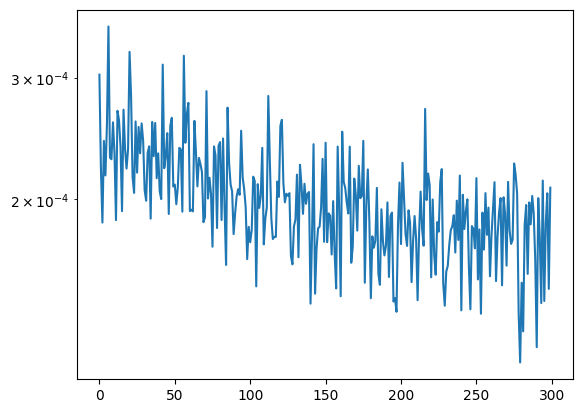

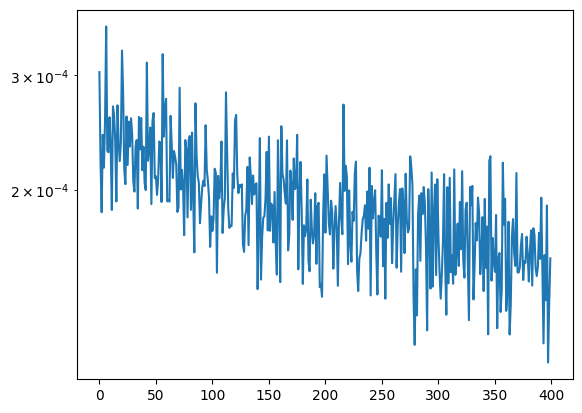

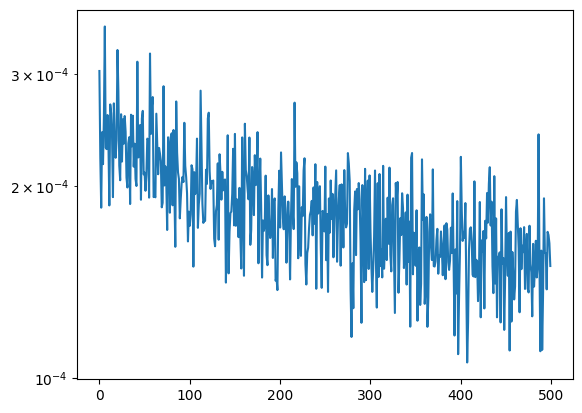

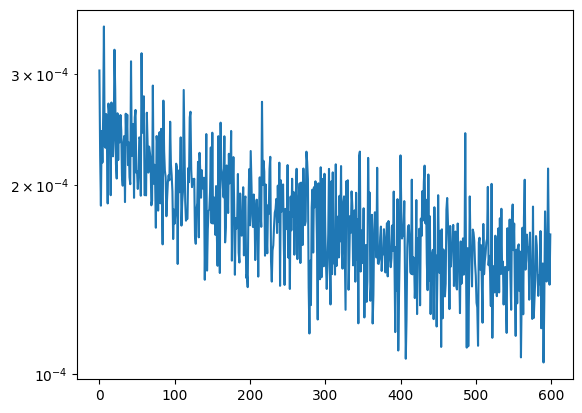

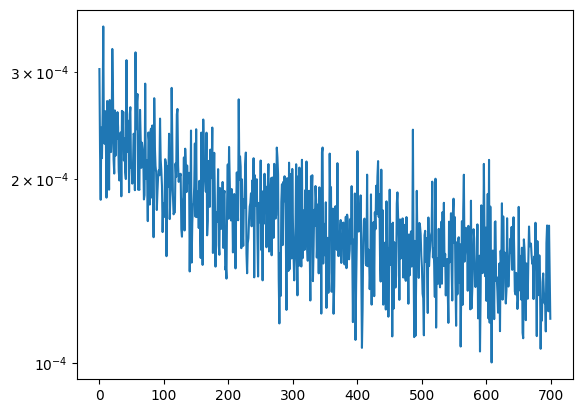

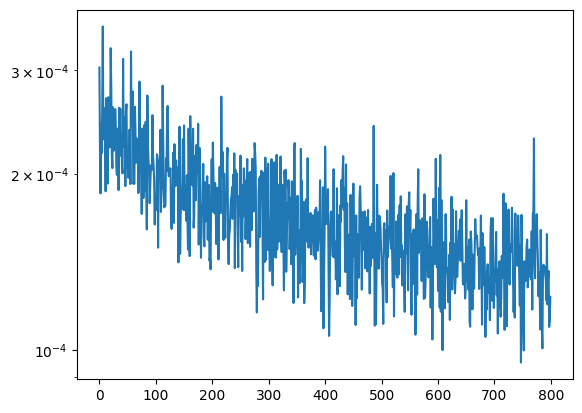

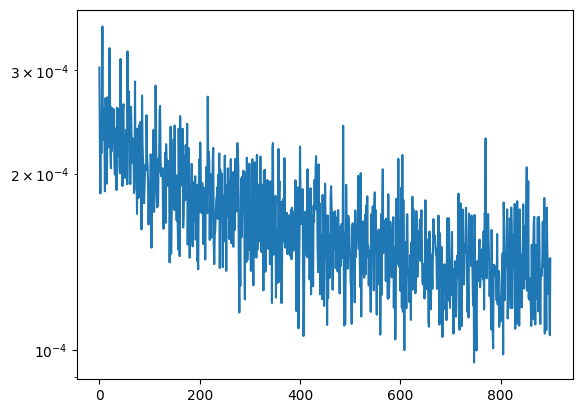

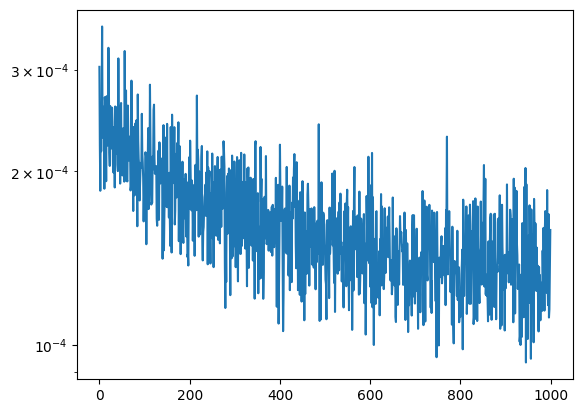

In [13]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-3)

n_training = 1000
check_every = 1
plot_every = 100

loss = np.zeros(n_training)


for t in range(1, n_training+1):
    vec = torch.randn_like(psi_coarse)
    
    Dvec = w_coarse(vec)
    
    norm = l2norm(Dvec)
    Dvec = Dvec / norm
    vec = vec / norm
    
    sDvec = torch.stack([Dvec])
    score = complex_mse_loss(layer.forward(sDvec), torch.stack([vec]))
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|N/A>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    

    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|N/A>", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")
        plt.show()

print()

In [14]:
torch.save(layer.state_dict(), "coarse.pt")
